# Model Calibration
## Why calibrate?
Calibration is the process of fine-tuning an agent-based model's input parameters so that its simulated outputs align with real-world data. Without calibration, the model might generate plausible-looking behavior that doesn’t actually reflect reality. Calibration improves the model’s credibility, predictive power, and policy relevance by ensuring it reproduces key observed patterns or outcomes from historical data.

## Calibration Process Overview
1. Define Calibration Targets:
Select measurable real-world data points (e.g., population size, disease prevalence, contraceptive use) that the model should replicate.

2. Identify Parameters to Tune:
Choose uncertain model parameters that strongly influence the outcomes but lack precise empirical estimates (e.g., agent behavior probabilities, environmental factors, etc.).

3. Choose a Calibration Method:
Use either:
- Manual/heuristic tuning (trial-and-error or expert knowledge), or
- Automated optimization (e.g., grid search, random search, genetic algorithms, or Bayesian methods) to systematically explore parameter space.

4. Define a Goodness-of-Fit Metric:
Quantify how well the model output matches the targets using metrics like root mean squared error (RMSE), likelihood scores, or custom error functions.

5. Run the Calibration:
Simulate the model repeatedly with different parameter values and evaluate performance using the fit metric.

6. Select Best-Fit Parameters:
Identify parameter sets that produce model outputs closest to observed data.

7. Validate (if possible):
Use separate data not involved in calibration to assess the model’s generalizability.

In this tutorial, we will walk through the basics of running both a manual and automated calibration. Choosing between manual and automated calibration depends on the model complexity, parameter uncertainty, available data, and computational resources. 

## Manual Calibration
Manual calibration involves adjusting parameters by hand based on expert knowledge or visual inspection of outputs. This can make sense when:
- The model has few parameters to tune
- You have strong domain knowledge about parameter ranges
- You are in the early stages of model development or prototyping
- The simulation is computationally expensive or you have limited computational resources
- You want to explore model behavior qualitatively

The plotting class (in plotting.py) can be used to visually inspect the outputs of common target parameters (e.g. CPR, method mix, TFR, etc.) and compare the model output vs real-world data.

## Automated Calibration
Automated calibration uses optimization algorithms (like Optuna’s Bayesian optimization) to efficiently search parameter space for the best fit. An automated calibration in FPsim uses the calibration and experiment classes to use Optuna's optimization methods to determine the best free parameters. This makes sense to use when:
- Your model has many uncertain parameters (e.g. 5+)
- You have access to compute resources to run many simulations (e.g. in parallel on a machine or VM with ample processing power, memory, and storage OR on a cloud computing platform)
- You have a large number of target parameters to which you want to calibrate with an unbiased approach
 
A hybrid approach can also be to start with a manual calibration to narrow down plausible ranges and understand model dynamics. Then switch to automated methods to fine-tune parameters and formalize the process. 

## Preparing the data

In order to run a calibration successfully, we need to ensure that the fpsim/locations directory contains a directory for the country being calibrated (i.e. 'fpsim/locations/kenya'). This directory should also contain:
- A model file (i.e. fpsim/locations/kenya/kenya.py)
- A data subdirectory with data for the desired calibration targets (see fpsim/locations/README.md for specific files and means of generating each), ideally with the most recently available comprehensive data to compare with the model output 

Ensure that the data in the aforementioned files are formatted in the same manner as those in `locations/kenya/data`.

## Running a Manual Calibration
### Imports
First, we import any needed packages. We also import the plotting class, which is useful in visually inspecting the model vs observed data.

In [1]:
import fpsim as fp
from fpsim import plotting as plt
import numpy as np

Starsim 2.0.0 (2024-10-01) — © 2023-2024 by IDM


### Setting Parameters

First, we set up our parameters for the simulation(s) used for calibration, including the country name and any specific sim params, such as the population size and start/end year of the sim.

In [2]:
country = 'kenya'

pars = fp.pars(location=country)
pars['n_agents'] = 10_000  # Population size
pars['end_year'] = 2020  # 1960 - 2020 is the normal date range


Next we set our free parameters to initial values that we will iteratively tune to optimize the model outputs (to be as close as possible to real-world data). The free parameters below are used for tuning:
- fecundity_var_low, fecundity_var_high
- exposure_factor
- spacing_pref
- primary_infertility
- age-based exposure (modified in {country}.py)
- parity-based exposure (modified in {country}.py)

We can also modify the contraceptive choice parameters, which can be useful especially in adjusting the model contraceptive prevalence rate. The `prob_use_year` parameter is helpful to adjust the CPR starting point (seen in the CPR trend plot), and the `prob_use_trend_par` parameter is helpful to adjust the slope in the CPR trend plot. Lastly, the `method_weights` array parameter is useful in tuning the method mix, for example - increasing the % of pill use and decreasing the % of IUD use. 

In [3]:
# Initial free parameters for calibration
pars['fecundity_var_low'] = 1
pars['fecundity_var_high'] = 1
pars['exposure_factor'] = 1

# Postpartum sexual activity correction or 'birth spacing preference'. Pulls values from {location}/data/birth_spacing_pref.csv by default
# Set all to 1 to reset. Option to use 'optimize-space-prefs.py' script in this directory to determine values
pars['spacing_pref']['preference'][:3] =  1  # Spacing of 0-6 months
pars['spacing_pref']['preference'][3:6] = 1  # Spacing of 9-15 months
pars['spacing_pref']['preference'][6:9] = 1  # Spacing of 18-24 months
pars['spacing_pref']['preference'][9:] =  1  # Spacing of 27-36 months

# Only other simulation free parameters are age-based exposure and parity-based exposure (which you can adjust manually in {country}.py) as well as primary_infertility (set to 0.05 by default)

# Adjust contraceptive choice parameters
cm_pars = dict(
    prob_use_year=2020,  # Time trend intercept
    prob_use_trend_par=0.06,   # Time trend parameter
    method_weights=np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])  # Weights for the methods in method_list in methods.py (excluding 'none', so starting with 'pill' and ending in 'othmod').
)
method_choice = fp.SimpleChoice(pars=cm_pars, location=country)     # The contraceptive choice module used (see methods.py for more documentation). We can select RandomChoice, SimpleChoice, or StandardChoice (StandardChoice is selected by default).

### Running the Simulation

We run the simulation with the free parameters specified above:

In [4]:
# Run the sim
sim = fp.Sim(pars=pars, contraception_module=method_choice)
sim.run()

  Running 1960 of 2020 ( 0/721) (0.12 s)  ———————————————————— 0%
  Running 1961 of 2020 (12/721) (0.23 s)  ———————————————————— 2%
  Running 1962 of 2020 (24/721) (0.48 s)  ———————————————————— 3%
  Running 1963 of 2020 (36/721) (0.75 s)  •——————————————————— 5%
  Running 1964 of 2020 (48/721) (0.99 s)  •——————————————————— 7%
  Running 1965 of 2020 (60/721) (1.23 s)  •——————————————————— 8%
  Running 1966 of 2020 (72/721) (1.47 s)  ••—————————————————— 10%
  Running 1967 of 2020 (84/721) (1.71 s)  ••—————————————————— 12%
  Running 1968 of 2020 (96/721) (1.95 s)  ••—————————————————— 13%
  Running 1969 of 2020 (108/721) (2.18 s)  •••————————————————— 15%
  Running 1970 of 2020 (120/721) (2.41 s)  •••————————————————— 17%
  Running 1971 of 2020 (132/721) (2.64 s)  •••————————————————— 18%
  Running 1972 of 2020 (144/721) (2.86 s)  ••••———————————————— 20%
  Running 1973 of 2020 (156/721) (3.09 s)  ••••———————————————— 22%
  Running 1974 of 2020 (168/721) (3.30 s)  ••••————————————————

Sim(<no label>; n=10000; 1960-2020; results: b=15550 ☠=9409 pop=14997)

### Plotting the Target Parameters

Once the sim run completes, we plot the sim results and the target parameters (comparing the model results vs real-world data). 

RMSE for method mix: 5.43
RMSE for overall use: 25.32


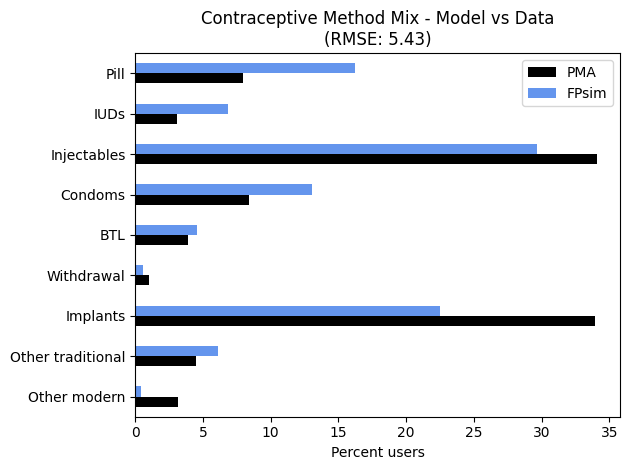

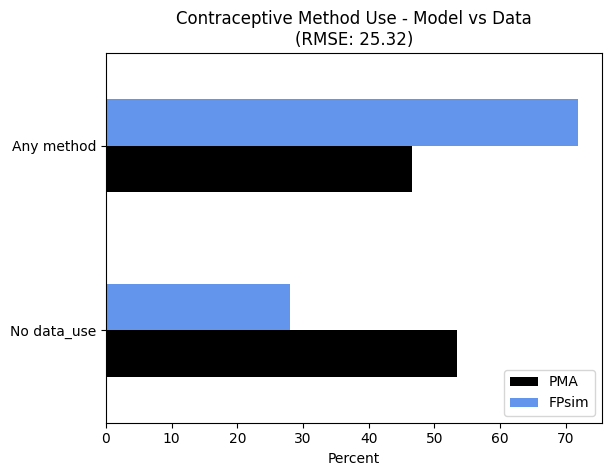

RMSE for CPR: 13.59


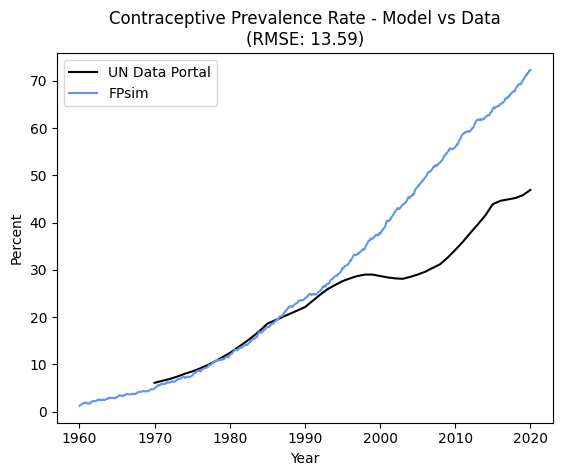

RMSE for Total Fertility Rate: 4.06


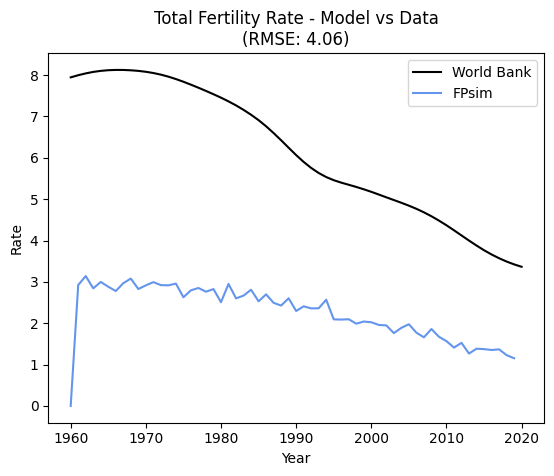

RMSE for Birth Spacing Bins: 9.56
Mean Age at First Birth - Model: 21.68, Data: inf
RMSE for Age at First Birth: inf


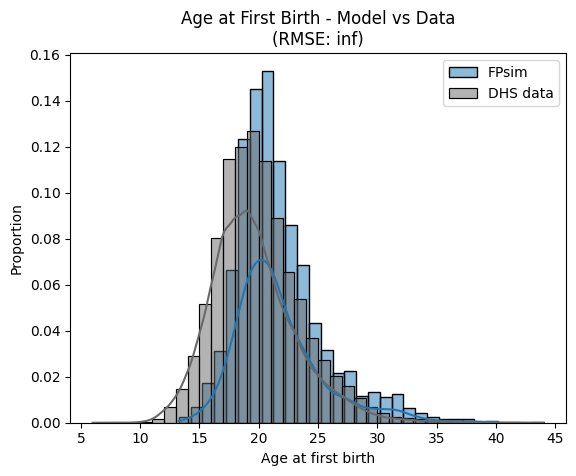

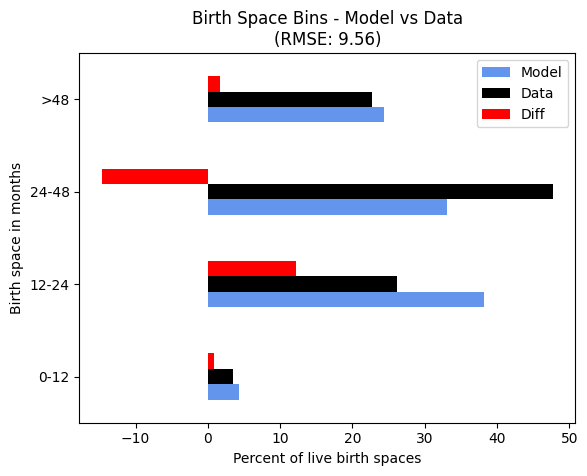

ASFR RMSE between model and data: 68.66378500590979


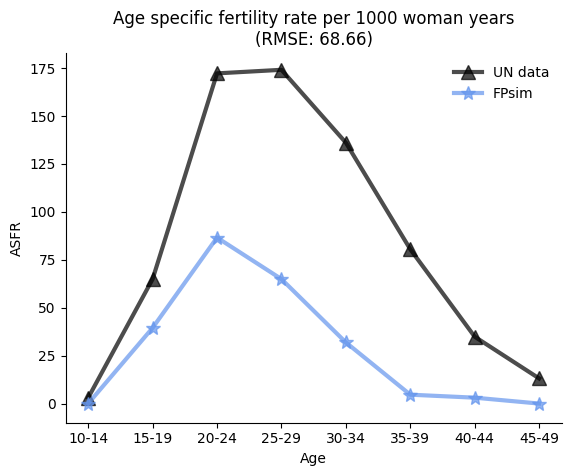

In [5]:
# Plot sim
sim.plot()

# Plotting class function which plots the primary calibration targets (method mix, method use, mcpr, total fertility rate, birth spacing, age at first birth, and age-specific fertility rate)
plt.plot_calib(sim)

We can see from the plots above that compared to the real-world data in 2020, our model has some adjustments that need to be made. We do this iteratively to see how we can get specific target parameters closer to reality. For example, the model currently results in a TFR that is too low, and the birth space bins have discrepancies (0-12mo is too high, 12-24mo is too high, and 24-48mo is too low). We can modify the free parameters to tune the model to adjust accordingly. Let's try increasing the exposure factor to increase the TFR and modifying the spacing preference factors to account for the current model/data differences:

In [6]:
# Initial free parameters for calibration
pars['fecundity_var_low'] = 1
pars['fecundity_var_high'] = 1
pars['exposure_factor'] = 1.5

# Last free parameter, postpartum sexual activity correction or 'birth spacing preference'. Pulls values from {location}/data/birth_spacing_pref.csv by default
# Set all to 1 to reset. Option to use 'optimize-space-prefs.py' script in this directory to determine values
pars['spacing_pref']['preference'][:4] = .6  # Spacing of 0-12 months
pars['spacing_pref']['preference'][4:8] = .3  # Spacing of 12-24 months
pars['spacing_pref']['preference'][8:16] = 1.7  # Spacing of 24-48 months
pars['spacing_pref']['preference'][16:] = 1  # Spacing of >48 months

  Running 1960 of 2020 ( 0/721) (0.06 s)  ———————————————————— 0%
  Running 1961 of 2020 (12/721) (0.20 s)  ———————————————————— 2%
  Running 1962 of 2020 (24/721) (0.44 s)  ———————————————————— 3%
  Running 1963 of 2020 (36/721) (0.79 s)  •——————————————————— 5%
  Running 1964 of 2020 (48/721) (1.04 s)  •——————————————————— 7%
  Running 1965 of 2020 (60/721) (1.27 s)  •——————————————————— 8%
  Running 1966 of 2020 (72/721) (1.55 s)  ••—————————————————— 10%
  Running 1967 of 2020 (84/721) (1.81 s)  ••—————————————————— 12%
  Running 1968 of 2020 (96/721) (2.07 s)  ••—————————————————— 13%
  Running 1969 of 2020 (108/721) (2.31 s)  •••————————————————— 15%
  Running 1970 of 2020 (120/721) (2.59 s)  •••————————————————— 17%
  Running 1971 of 2020 (132/721) (2.83 s)  •••————————————————— 18%
  Running 1972 of 2020 (144/721) (3.08 s)  ••••———————————————— 20%
  Running 1973 of 2020 (156/721) (3.31 s)  ••••———————————————— 22%
  Running 1974 of 2020 (168/721) (3.55 s)  ••••————————————————

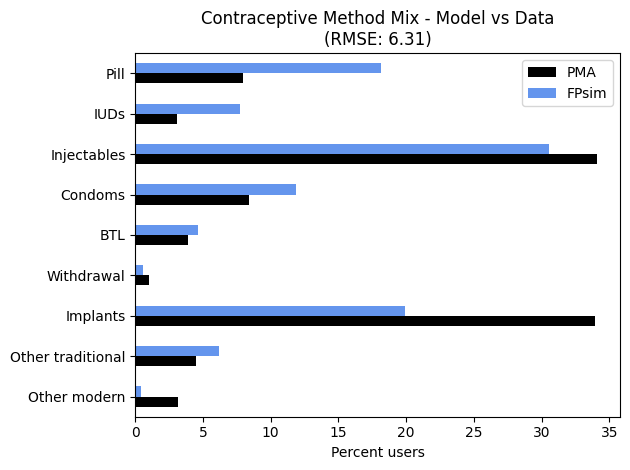

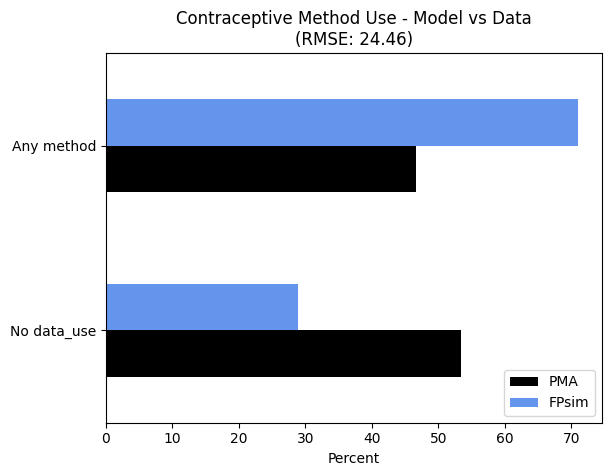

RMSE for CPR: 13.24


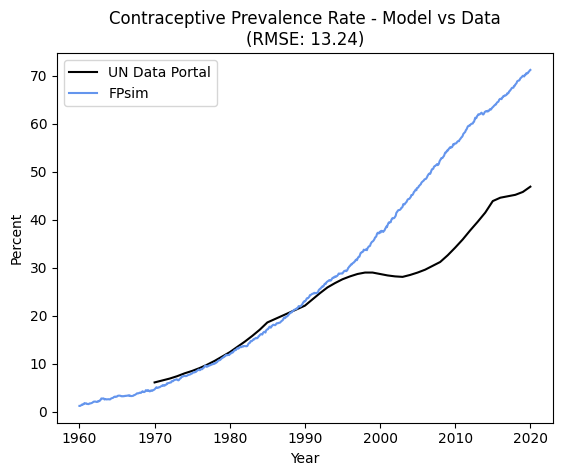

RMSE for Total Fertility Rate: 3.69


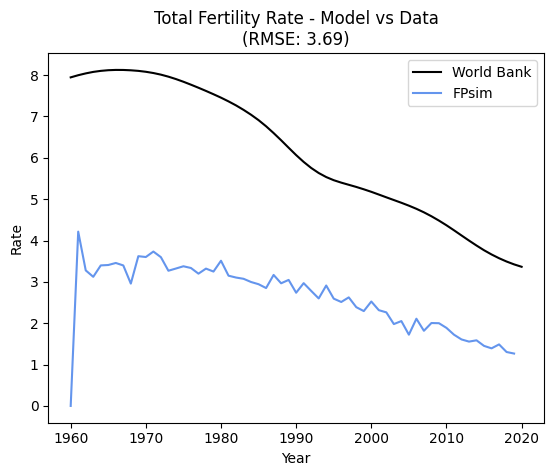

RMSE for Birth Spacing Bins: 7.51
Mean Age at First Birth - Model: 21.12, Data: inf
RMSE for Age at First Birth: inf


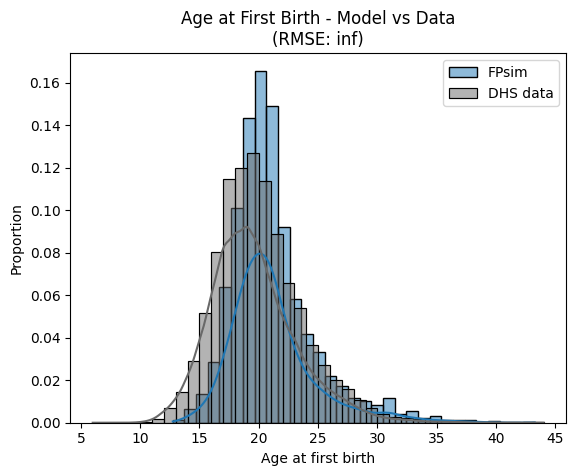

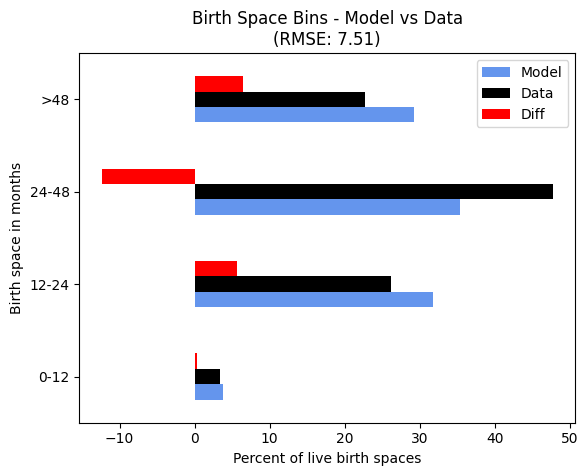

ASFR RMSE between model and data: 69.03255516478451


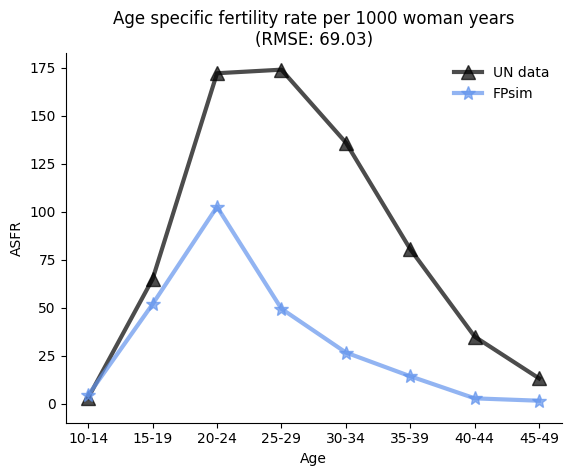

In [7]:
# Re-run the sim
sim = fp.Sim(pars=pars, contraception_module=method_choice)
sim.run()
plt.plot_calib(sim)

Our adjustments helped move the model results towards the real-world trends thankfully! As we iteratively modify the free parameters, we can both improve the calibration of the model and simultaneously learn how the parameters affect the model behavior. For example, as increasing the exposure_factor increased the TFR (which is still too low), we can increase it again in hopes of making it closer to the data. 

There are different strategies of fine-tuning these parameters manually, but one method is to modify the free parameters to get 1-2 target parameters as close as we can before then focusing on a different target parameter to improve via additional free parameter modifications. As these models are quite dynamic, changing one free parameter will often change several target parameters (some more significantly than others); thus, it's worth taking note of which target parameters change and in what direction(s). 

There is an initial learning curve to understanding which free parameters affect which target parameters, but tuning the model by visual inspection of model vs data in the plots becomes easier and quicker over time.

Let's try increasing the exposure_factor once more and also modifying one of the contraceptive choice parameters (`method_weights`) to calibrate the method mix (increasing weights for those with percentages too low and decreasing weights for those with percentages too high):

In [8]:
# Initial free parameters for calibration
pars['fecundity_var_low'] = 1
pars['fecundity_var_high'] = 1
pars['exposure_factor'] = 2.5

# Last free parameter, postpartum sexual activity correction or 'birth spacing preference'. Pulls values from {location}/data/birth_spacing_pref.csv by default
# Set all to 1 to reset. Option to use 'optimize-space-prefs.py' script in this directory to determine values
pars['spacing_pref']['preference'][:4] = .6  # Spacing of 0-12 months
pars['spacing_pref']['preference'][4:8] = .3  # Spacing of 12-24 months
pars['spacing_pref']['preference'][8:16] = 1.7  # Spacing of 24-48 months
pars['spacing_pref']['preference'][16:] = 1  # Spacing of >48 months

# Adjust contraceptive choice parameters
cm_pars = dict(
    prob_use_year=2020,  # Time trend intercept
    prob_use_trend_par=0.06,   # Time trend parameter
    force_choose=False,        # Whether to force non-users to choose a method ('False' by default)
    method_weights=np.array([.5, .5, 1, .7, 1, 1, 1.3, .8, 3])  # Weights for the methods in method_list in methods.py (excluding 'none', so starting with 'pill' and ending in 'othmod').
)
method_choice = fp.SimpleChoice(pars=cm_pars, location=country)

  Running 1960 of 2020 ( 0/721) (0.06 s)  ———————————————————— 0%
  Running 1961 of 2020 (12/721) (0.16 s)  ———————————————————— 2%
  Running 1962 of 2020 (24/721) (0.43 s)  ———————————————————— 3%
  Running 1963 of 2020 (36/721) (0.80 s)  •——————————————————— 5%
  Running 1964 of 2020 (48/721) (1.11 s)  •——————————————————— 7%
  Running 1965 of 2020 (60/721) (1.38 s)  •——————————————————— 8%
  Running 1966 of 2020 (72/721) (1.66 s)  ••—————————————————— 10%
  Running 1967 of 2020 (84/721) (1.93 s)  ••—————————————————— 12%
  Running 1968 of 2020 (96/721) (2.22 s)  ••—————————————————— 13%
  Running 1969 of 2020 (108/721) (2.48 s)  •••————————————————— 15%
  Running 1970 of 2020 (120/721) (2.74 s)  •••————————————————— 17%
  Running 1971 of 2020 (132/721) (2.97 s)  •••————————————————— 18%
  Running 1972 of 2020 (144/721) (3.23 s)  ••••———————————————— 20%
  Running 1973 of 2020 (156/721) (3.47 s)  ••••———————————————— 22%
  Running 1974 of 2020 (168/721) (3.71 s)  ••••————————————————

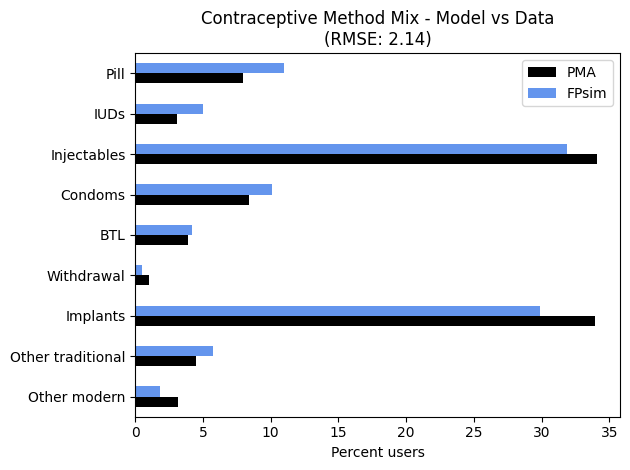

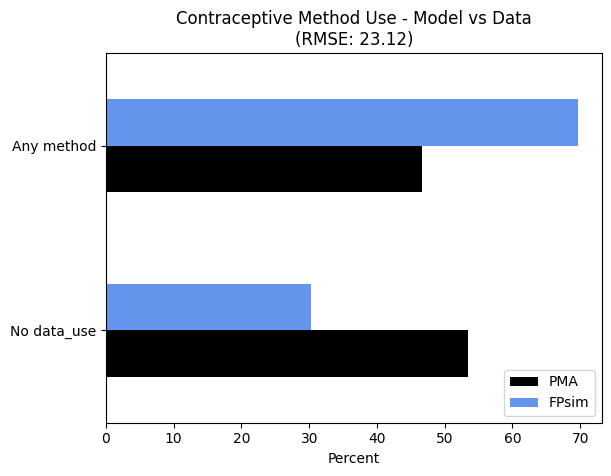

RMSE for CPR: 12.06


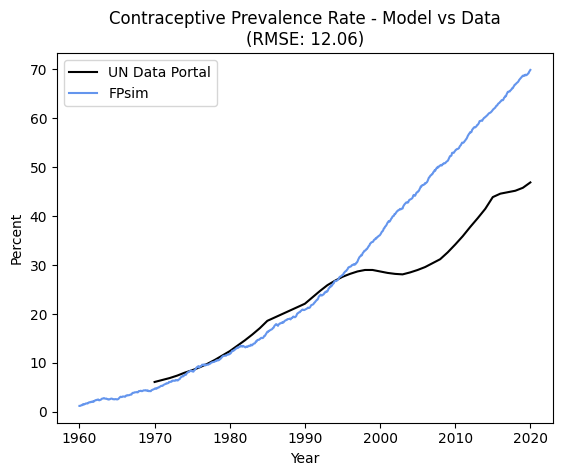

RMSE for Total Fertility Rate: 2.69


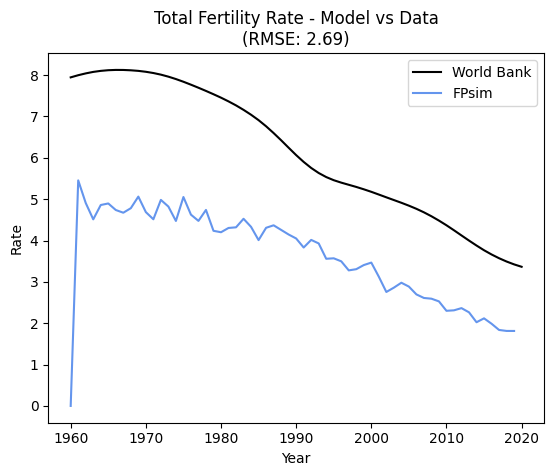

RMSE for Birth Spacing Bins: 9.77
Mean Age at First Birth - Model: 20.41, Data: inf
RMSE for Age at First Birth: inf


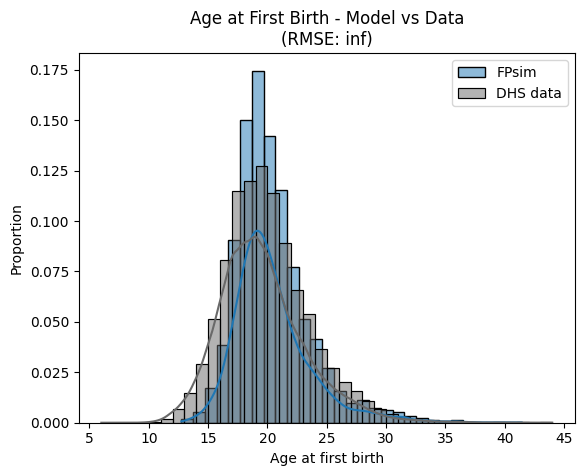

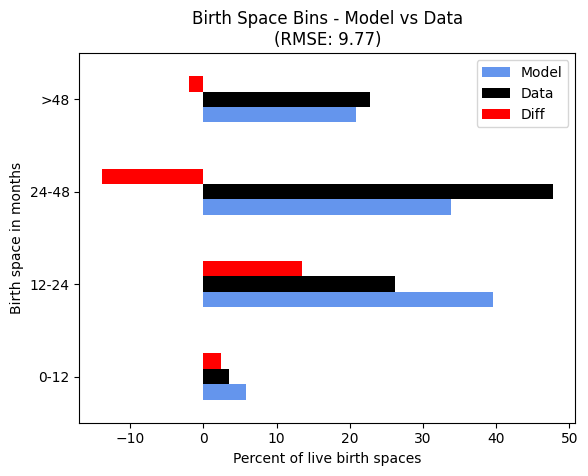

ASFR RMSE between model and data: 58.00795706233894


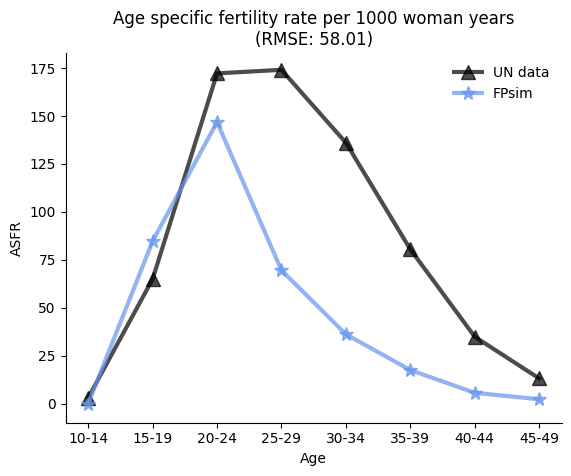

In [9]:
# Re-run the sim
sim = fp.Sim(pars=pars, contraception_module=method_choice)
sim.run()
plt.plot_calib(sim)

Both of these changes helped us improve these target parameters! The TFR (and ASFR) both shifted closer to the data, and the method mix looks much closer as well. As was mentioned however, changing free parameters doesn't necessarily adjust target parameters 1-1 (they rarely do!); notice how these changes resulted in the birth space bin of 12-24mo jumping back up when we had tuned it to be lower (and closer to the data) previously. The good news is that we already learned how to adjust the birth space bins by modifying the spacing_pref param; thus, we can keep the free parameters we've adjusted so far and decrease the spacing_pref 12-24mo weight again to continue the calibration. 

We continue in this manner, iteratively improving the target parameters to which we are calibrating. We can either calibrate solely in this manner (if limited in computational resources and/or in the early stages of model development), or we can perform an approximate calibration and then use the chosen free parameters to help narrow the parameter ranges we want to sweep in an automatic calibration.

## Running an Automated Calibration
### Setting the Parameters

If running an automated calibration, we do the same step of defining the simulation parameters. We then define a dictionary containing parameters we want to sweep in the calibration in one of the two following formats:
        
        Either a dict of arrays or lists in order best-low-high, e.g.::

            calib_pars = dict(
                exposure_factor    = [1.0, 0.5,  1.5],
                fecundity_var_high = [1,   0.75, 3.0],
            )

        Or the same thing, as a dict of dicts::

            calib_pars = dict(
                exposure_factor    = dict(best=1.0, low=0.5,  high=1.5),
                fecundity_var_high = dict(best=1,   low=0.75, high=3.0),
            )
            

In [10]:
pars = fp.pars(location=country)
pars['n_agents'] = 100  # Population size; set very small here only for the purpose of runtime
pars['end_year'] = 2020  # 1960 - 2020 is the normal date range

# Free parameters for calibration
freepars = dict(
        fecundity_var_low = [0.95, 0.925, 0.975],       # [best, low, high]
        fecundity_var_high = [1.05, 1.0, 1.3],
        exposure_factor = [2.0, 0.95, 2.5],
)

When setting up calibration parameters for a model, the 'best', 'low', and 'high' values define the starting point and the allowable search space for optimization. The 'best' value represents your current best guess or default setting based on prior knowledge, literature, or previous model use. It is not used to guide the optimization algorithm directly but serves as a baseline for comparison to assess how much the calibration improves model fit. The 'low' and 'high' values define the range of plausible values that Optuna will explore during calibration. These should be wide enough to allow the optimizer to find better-fitting parameter combinations, but constrained enough to reflect realistically plausible bounds. Thoughtful selection of these values ensures both meaningful calibration results and computational efficiency.

Once we set up our parameters and free parameters, we can define and run the calibration. We can optionally provide a specific number of trials (`n_trials`) used as well. This indicates the number of trials, i.e. sim runs, per worker. The number of workers (by default per the Calibration class, is the number of CPUs). For the sake of the runtime for this tutorial, we will specify a low number of trials here. Other optional parameters can be found in the documentation in the Calibration class (`fpsim/calibration.py`).

### Running the Calibration

In [11]:
calibration = fp.Calibration(pars, calib_pars=freepars, n_trials=2)
calibration.calibrate()
calibration.summarize()



————————————————————
Starting calibration
————————————————————

Settings:
#0. 'name':      'fpsim_calibration'
#1. 'db_name':   'fpsim_calibration.db'
#2. 'storage':   'sqlite:///fpsim_calibration.db'
#3. 'n_trials':  2
#4. 'n_workers': 12
Removed "fpsim_calibration.db"
Removed existing calibration fpsim_calibration.db


[I 2025-06-13 10:45:17,644] A new study created in RDB with name: fpsim_calibration


Output: {'fecundity_var_low': 0.9457797360620365, 'fecundity_var_high': 1.29743576068496, 'exposure_factor': 2.495783499567202}, time: 57.16970086097717
  Running 1960 of 2020 ( 0/721) (0.09 s)  ———————————————————— 0%
  Running 1961 of 2020 (12/721) (0.19 s)  ———————————————————— 2%
  Running 1962 of 2020 (24/721) (0.31 s)  ———————————————————— 3%
  Running 1963 of 2020 (36/721) (0.40 s)  •——————————————————— 5%
  Running 1964 of 2020 (48/721) (0.50 s)  •——————————————————— 7%
  Running 1965 of 2020 (60/721) (0.62 s)  •——————————————————— 8%
  Running 1966 of 2020 (72/721) (0.68 s)  ••—————————————————— 10%
  Running 1967 of 2020 (84/721) (0.74 s)  ••—————————————————— 12%
  Running 1968 of 2020 (96/721) (0.79 s)  ••—————————————————— 13%
  Running 1969 of 2020 (108/721) (0.85 s)  •••————————————————— 15%
  Running 1970 of 2020 (120/721) (0.92 s)  •••————————————————— 17%
  Running 1971 of 2020 (132/721) (0.96 s)  •••————————————————— 18%
  Running 1972 of 2020 (144/721) (1.02 s)  •••

(np.float64(144.5644965726485), np.float64(112.98488976197832))

### Analyzing the Results

We can see that the calibration provided us with the optimal set of free parameters as well as indicated the reduction in mismatch (and percentage improvement) after the calibration was run. The mismatch is calculated using the default_flags that are set to `1` in the Experiment class (`experiment.py`), some of which can be disabled if desired by setting to `0`. Additionally, we can analyze the calibration results by using some of the calibration class plotting functions: 

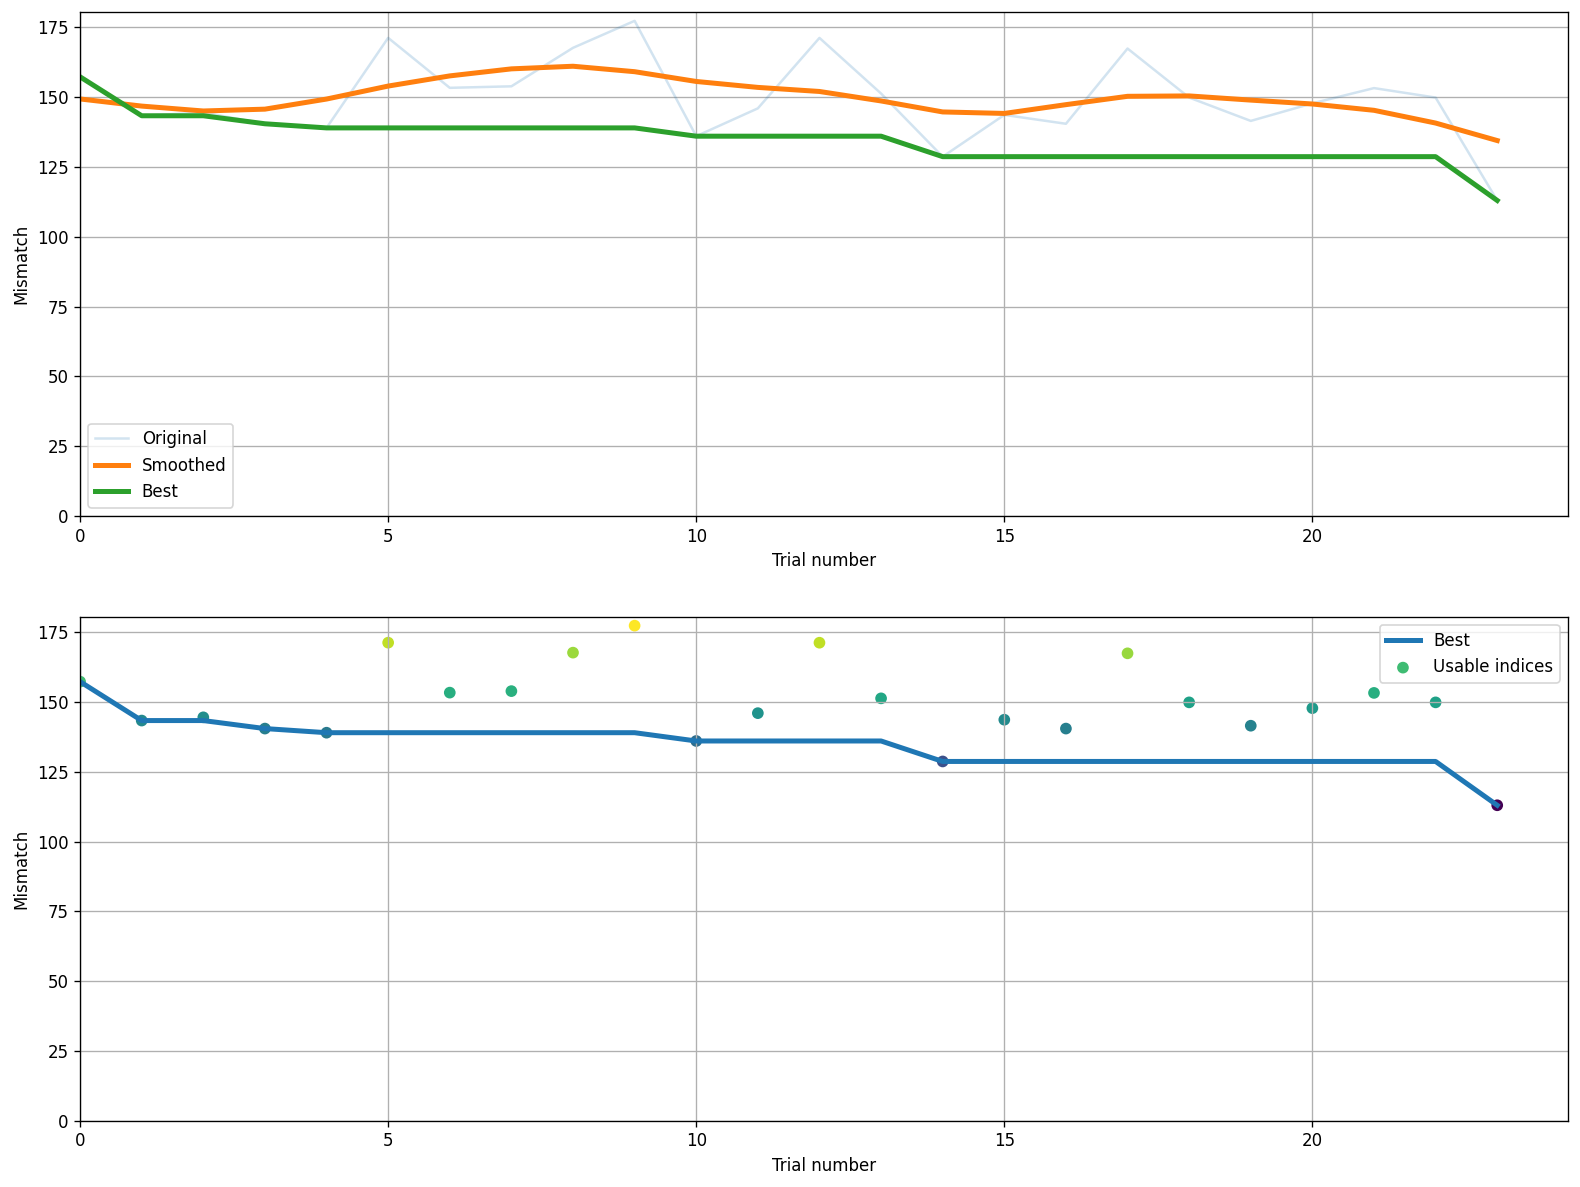

In [12]:
'''
The plot_trend function below visualizes the evolution of the mismatch metric over trials during the calibration and highlights the progression of the best (lowest) mismatch values. It's useful to see whether the calibration is converging or plateauing and identify how quickly the algorithm found good parameter regions. 
'''

fig = calibration.plot_trend()


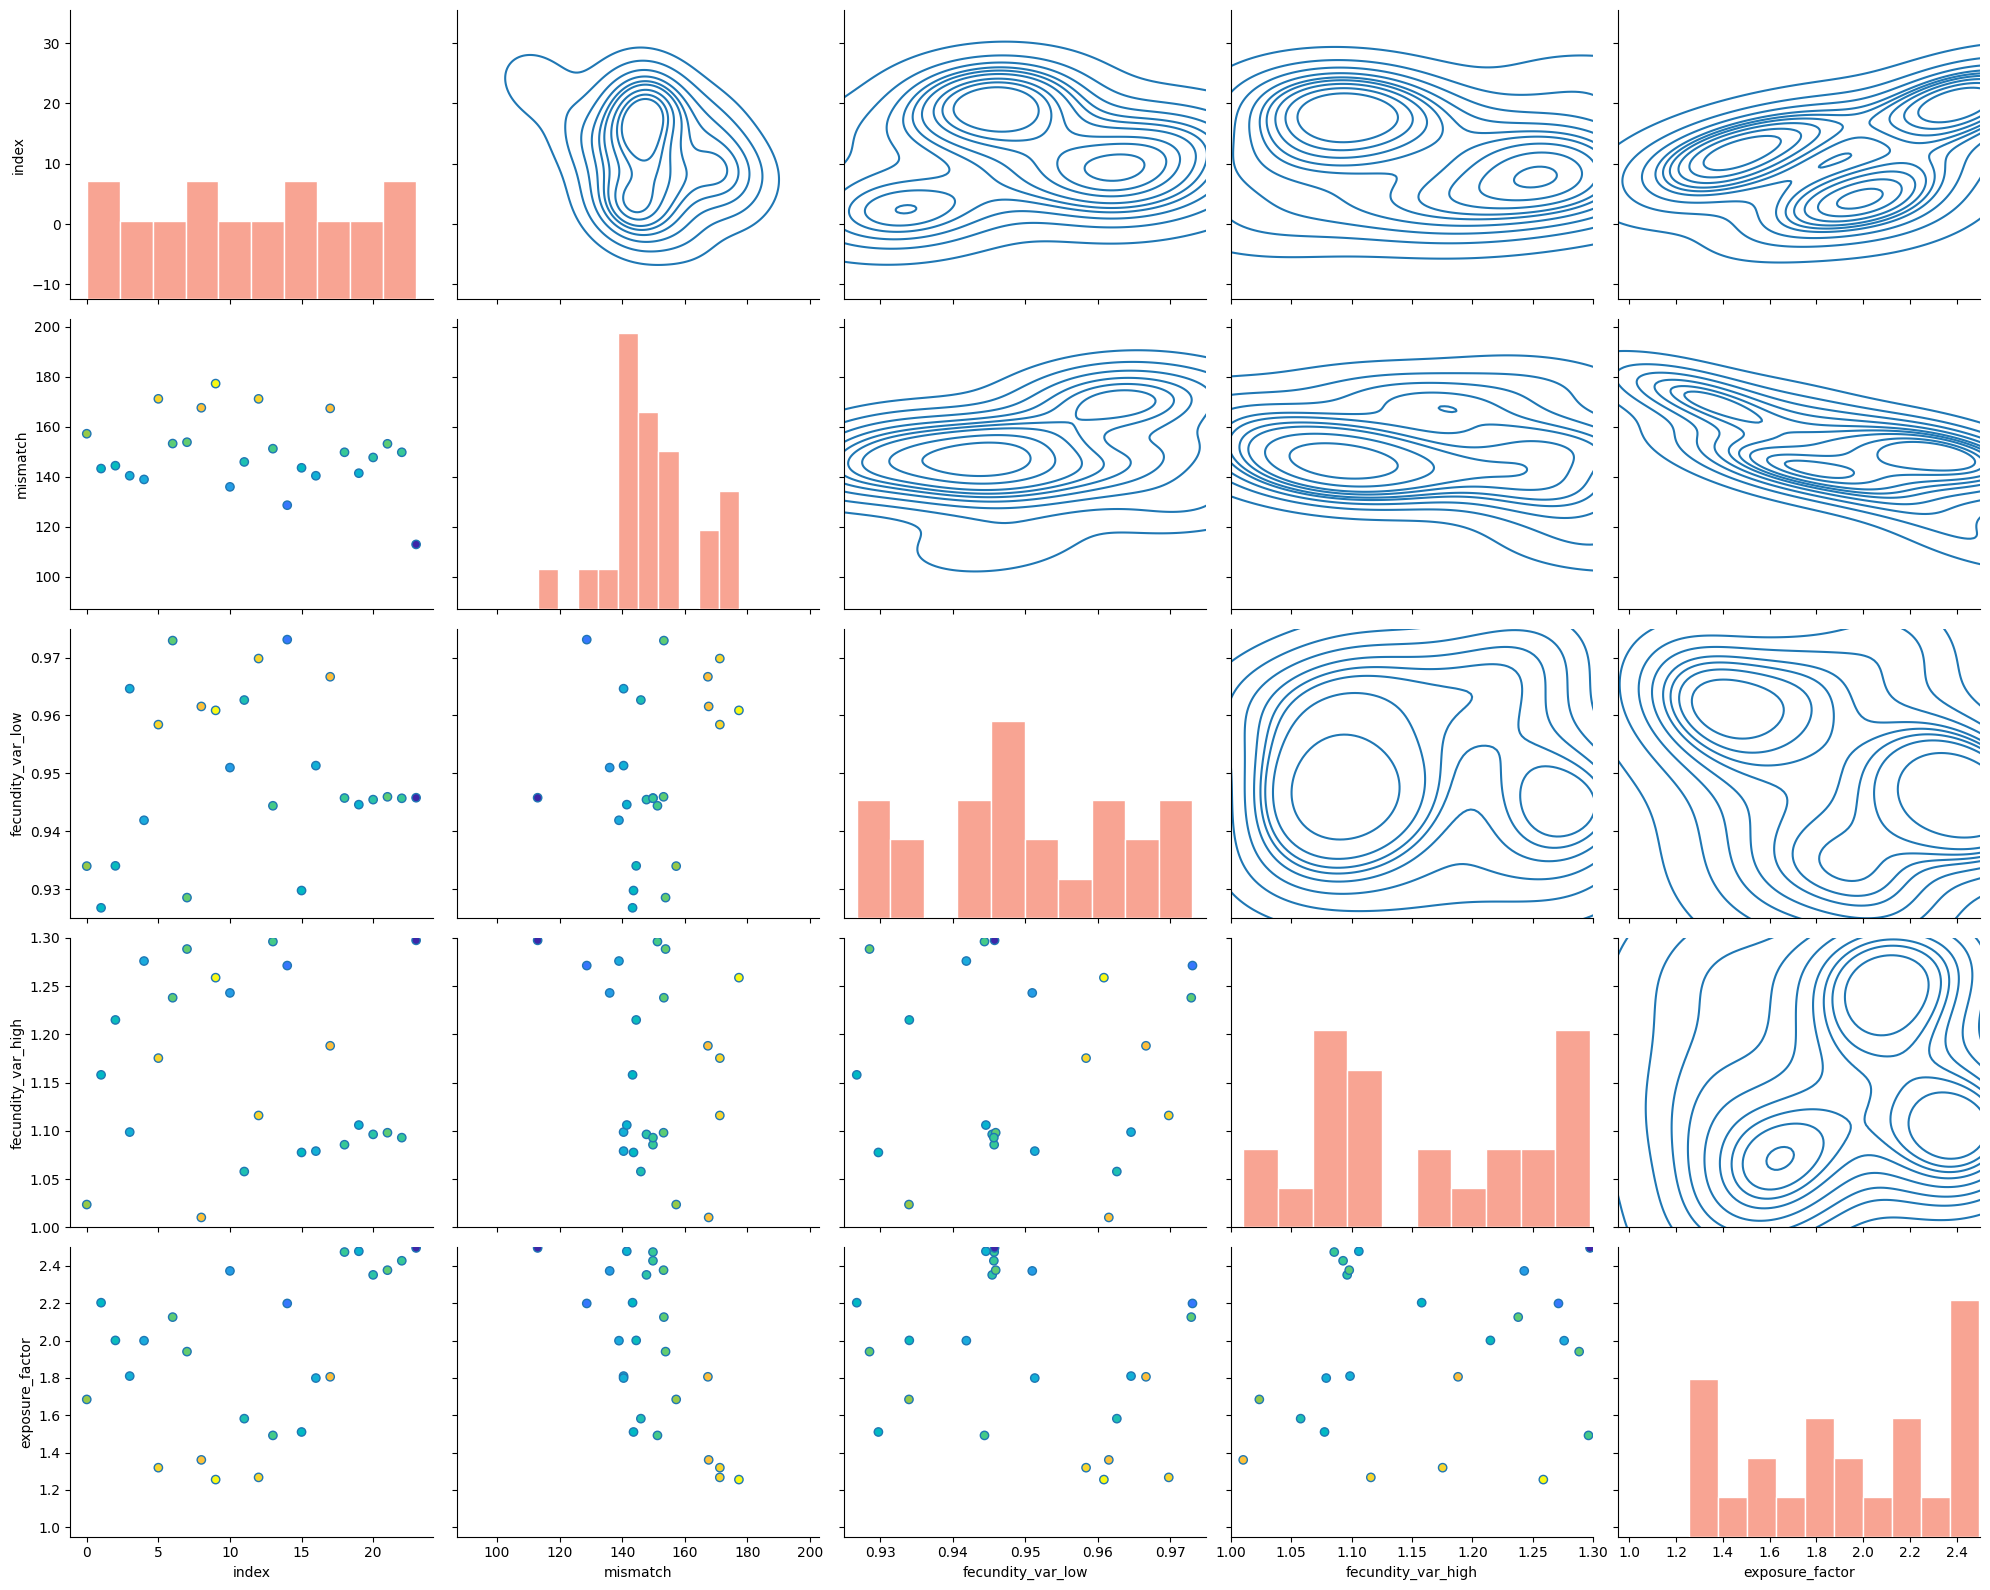

In [13]:
'''
The plot_best function below visualizes only the parameter sets from trials that performed best, using pairwise plots colored by mismatch. The pairwise plot matrix shows scatterplots colored by mismatch in the lower triangle, histograms of parameter distributions on the diagonal, and KDE contours in the upper triangle. These can help identify correlations between parameters that lead to good performance. It's useful for exploring the parameter space that led to good calibration fits.
'''

fig = calibration.plot_best()


We can then continue to adjust the free parameter ranges, iteratively setting the 'Best parameter values' as the next 'best' params in the free parameter dictionary.

### When is a Calibration Sufficient?
Deciding when a calibration is sufficient is part science, part judgment. While there is no universal threshold, you can use a combination of quantitative indicators and practical considerations to determine sufficiency. A key metric to monitor is the mismatch — the numerical value representing the error between model output and observed data. Calibration is generally considered sufficient when the best mismatch has stabilized over a series of trials, indicating that further optimization yields diminishing returns.

You can visualize this trend using plot_trend(), which shows how the mismatch improves over time. A flattening curve suggests that the optimizer has converged. Additionally, plot_best() helps examine the distribution of parameters from the best-performing trials. A concentrated cluster of low-mismatch solutions is a good sign of a stable and well-behaved calibration.

It’s also important to assess parameter realism. Calibrated values should fall well within plausible ranges and not sit at the bounds of their allowed values — this may indicate a need to expand parameter ranges or run more trials. The quality of fit across all outputs should be visually and statistically evaluated using post-calibration plots. A good calibration improves fit across multiple targets without overfitting any single metric.

Lastly, reproducibility is key: rerunning the calibration should produce similar results. If the results vary significantly between runs/with different seeds, consider increasing the number of trials or reviewing your parameter bounds. Calibration is complete not just when the mismatch is low, but when the parameter values are stable, plausible, and generate outputs that align well with observed data.




## Using the Optimized Free Parameters

Once we calibrate a model and determine the optimal set of free parameters, we can use them for a model either by setting them when defining the simulation 'pars' dictionary in an analysis script (as we did earlier in this tutorial), or if we want to continually use them we can set them in the `scalar_pars` function in the `{model}.py` file (i.e. 'kenya.py') like so:

In [14]:
def scalar_pars():
    scalar_pars = {
        'location':             'kenya',
        'postpartum_dur':       23,
        'exposure_factor':        1.5,
    }
    return scalar_pars